<a href="https://colab.research.google.com/github/Niharika-Saha/Adaptive-Bacterial-Antibiotic-Resistance-Prediction-using-Meta-Learning/blob/main/meta-learning-models/ablations/ProtoMAML%2Bhirarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 - imports and device
import os
import random
import math
from collections import Counter, defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# Cell 2 - config + load data
CSV_PATH = "megares_fasta_processed.csv"  # <- change if needed

# Basic hyperparams you can tune
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

# Read CSV
df = pd.read_csv(CSV_PATH)
print("Raw data shape:", df.shape)
print("Columns:", df.columns.tolist())

# Ensure required columns exist
required_cols = ['sequence', 'group', 'mechanism', 'drug_class', 'gc_content', 'seq_len']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

# Simple cleaning
df = df.dropna(subset=['sequence', 'group', 'mechanism', 'drug_class']).reset_index(drop=True)
df['sequence'] = df['sequence'].astype(str).str.upper().str.replace(r'[^ACGT]', '', regex=True)
df['seq_len'] = df['sequence'].str.len()
df = df[df['seq_len'] > 0].reset_index(drop=True)
print("After cleaning:", df.shape)

Raw data shape: (8733, 9)
Columns: ['gene_id', 'header', 'sequence', 'seq_len', 'gc_content', 'type', 'drug_class', 'mechanism', 'group']
After cleaning: (8733, 9)


In [ ]:
# Cell 3 - build unique mappings
group_map = df[['group', 'mechanism', 'drug_class']].drop_duplicates()

groups = sorted(df['group'].unique().tolist())
mechs = sorted(df['mechanism'].unique().tolist())
classes = sorted(df['drug_class'].unique().tolist())

group2idx = {g: i for i, g in enumerate(groups)}
idx2group = {i: g for g, i in group2idx.items()}
mech2idx = {m: i for i, m in enumerate(mechs)}
idx2mech = {i: m for m, i in mech2idx.items()}
class2idx = {c: i for i, c in enumerate(classes)}
idx2class = {i: c for c, i in class2idx.items()}

group_to_mech_idx = {group2idx[row.group]: mech2idx[row.mechanism] for _, row in group_map.iterrows()}
group_to_class_idx = {group2idx[row.group]: class2idx[row.drug_class] for _, row in group_map.iterrows()}

print(f"Groups: {len(groups)}, Mechanisms: {len(mechs)}, Drug classes: {len(classes)}")


Groups: 1448, Mechanisms: 233, Drug classes: 59


In [ ]:
# Cell 4 - filter tiny groups and split mechanisms into train/val/test
MIN_SAMPLES_PER_GROUP = 10  # filter groups with fewer sequences
keep_groups = df.groupby('group').filter(lambda g: len(g) >= MIN_SAMPLES_PER_GROUP)['group'].unique().tolist()
df = df[df['group'].isin(keep_groups)].reset_index(drop=True)
print("After filtering small groups:", df.shape, "groups:", len(df['group'].unique()))

# Mechanism-level split (so test contains unseen mechanisms ideally)
mech_list = sorted(df['mechanism'].unique())
train_mechs, temp_mechs = train_test_split(mech_list, test_size=0.30, random_state=RANDOM_SEED, shuffle=True)
val_mechs, test_mechs = train_test_split(temp_mechs, test_size=0.50, random_state=RANDOM_SEED, shuffle=True)

train_df = df[df['mechanism'].isin(train_mechs)].reset_index(drop=True)
val_df = df[df['mechanism'].isin(val_mechs)].reset_index(drop=True)
test_df = df[df['mechanism'].isin(test_mechs)].reset_index(drop=True)

print(f"Mechanisms (train/val/test): {len(train_mechs)}/{len(val_mechs)}/{len(test_mechs)}")
print(f"Samples (train/val/test): {len(train_df)}/{len(val_df)}/{len(test_df)}")


After filtering small groups: (6368, 9) groups: 107
Mechanisms (train/val/test): 30/6/7
Samples (train/val/test): 5076/452/840


In [ ]:
# Cell 5 - k-mer tokenization and vocabulary from training sequences
KMER_K = 5
PAD, UNK = "<PAD>", "<UNK>"

def kmers_from_seq(seq, k=KMER_K):
    L = len(seq)
    if L < k:
        return []
    return [seq[i:i+k] for i in range(L-k+1)]

# Build vocab only from train sequences
counter = Counter()
for s in train_df['sequence']:
    counter.update(kmers_from_seq(s, KMER_K))

tokens = [PAD, UNK] + sorted(counter.keys())
stoi = {t:i for i,t in enumerate(tokens)}
itos = {i:t for t,i in stoi.items()}
VOCAB_SIZE = len(stoi)
print("Vocab size:", VOCAB_SIZE)

def encode_ids(seq, k=KMER_K):
    arr = kmers_from_seq(seq, k)
    if not arr:
        return [stoi[UNK]]
    return [stoi.get(tok, stoi[UNK]) for tok in arr]

def encode_df_to_ids(dfp):
    ids = [encode_ids(s, KMER_K) for s in dfp['sequence'].tolist()]
    nums = dfp[['gc_content', 'seq_len']].to_numpy(np.float32)
    y = dfp['group'].to_numpy()   # group labels used for tasks
    return ids, nums, y

train_ids, train_num, ytr = encode_df_to_ids(train_df)
val_ids, val_num, yva = encode_df_to_ids(val_df)
test_ids, test_num, yte = encode_df_to_ids(test_df)


Vocab size: 1026


In [ ]:
# Cell 6 - padding and reverse-complement augmentation
def pick_max_len(list_of_ids, pct=0.90):
    lens = np.array([len(x) for x in list_of_ids])
    return int(np.clip(np.quantile(lens, pct), 16, 2048))

MAX_LEN = 512
print("MAX_LEN (set):", MAX_LEN)

def pad_sequences(list_of_ids, max_len=MAX_LEN, pad_id=None):
    if pad_id is None:
        pad_id = stoi[PAD]
    out = np.full((len(list_of_ids), max_len), pad_id, dtype=np.int64)
    for i, seq in enumerate(list_of_ids):
        s = seq[:max_len]
        out[i, :len(s)] = s
    return out

Xtr_tok = pad_sequences(train_ids, MAX_LEN)
Xva_tok = pad_sequences(val_ids, MAX_LEN)
Xte_tok = pad_sequences(test_ids, MAX_LEN)

# reverse complement helper
_comp = str.maketrans("ACGT", "TGCA")
def rev_comp(seq):
    return seq.translate(_comp)[::-1]

train_ids_rc = [encode_ids(rev_comp(s), KMER_K) for s in train_df['sequence'].tolist()]
Xtr_tok_rc = pad_sequences(train_ids_rc, MAX_LEN)

# normalize numeric features using train stats
num_mean = train_num.mean(axis=0, keepdims=True)
num_std = train_num.std(axis=0, keepdims=True) + 1e-6
train_num = (train_num - num_mean) / num_std
val_num = (val_num - num_mean) / num_std
test_num = (test_num - num_mean) / num_std


MAX_LEN (set): 512


In [ ]:
# Cell 7 - index mapping and episodic task creation with mechanism-aware sampling
def group_index(y):
    d = defaultdict(list)
    for i, lab in enumerate(y):
        d[lab].append(i)
    return {k: np.asarray(v, dtype=int) for k,v in d.items()}

idx_tr = group_index(train_df['group'].to_numpy())
idx_va = group_index(val_df['group'].to_numpy())
idx_te = group_index(test_df['group'].to_numpy())

def _choose_tokens_with_rc(Xtok, Xtok_rc, ids, rng, rc_prob=0.25):
    if Xtok_rc is None or rc_prob <= 0:
        return Xtok[ids]
    mask = rng.random(len(ids)) < rc_prob
    out = Xtok[ids].copy()
    if mask.any():
        out[mask] = Xtok_rc[ids[mask]]
    return out

def create_mechanism_aware_tasks(X_tok, X_num, y_groups, idx_map, group_to_mech,
                                num_tasks=1000, N=5, K=5, Q=10, seed=42,
                                X_tok_rc=None, rc_prob=0.25, augment_rc=False,
                                mech_diversity=0.6):
    rng = np.random.default_rng(seed)
    tasks = []
    valid_groups = [g for g, ids in idx_map.items() if len(ids) >= K + Q]
    if len(valid_groups) < N:
        return tasks

    # Create mechanism to groups mapping
    mech_to_groups = defaultdict(list)
    for group in valid_groups:
        mech_idx = group_to_mech[group2idx[group]]
        mech_to_groups[mech_idx].append(group)

    for _ in range(num_tasks):
        if rng.random() < mech_diversity and len(mech_to_groups) >= N:
            # Sample groups from different mechanisms
            unique_mechs = list(mech_to_groups.keys())
            selected_mechs = rng.choice(unique_mechs, size=min(N, len(unique_mechs)), replace=False)
            me_sel = []
            for mech in selected_mechs:
                available_groups = mech_to_groups[mech]
                if available_groups:
                    me_sel.append(rng.choice(available_groups))
            # If we don't have enough groups from diverse mechanisms, fill randomly
            while len(me_sel) < N:
                remaining = [g for g in valid_groups if g not in me_sel]
                if not remaining:
                    break
                me_sel.append(rng.choice(remaining))
        else:
            # Regular sampling
            me_sel = rng.choice(valid_groups, size=N, replace=False)

        s_tok, s_num, s_y = [], [], []
        q_tok, q_num, q_y = [], [], []

        for j, g in enumerate(me_sel):
            ids = rng.choice(idx_map[g], size=K+Q, replace=False)
            s_idx, q_idx = ids[:K], ids[K:K+Q]
            if augment_rc and (X_tok_rc is not None):
                s_tok.append(_choose_tokens_with_rc(X_tok, X_tok_rc, s_idx, rng, rc_prob))
                q_tok.append(_choose_tokens_with_rc(X_tok, X_tok_rc, q_idx, rng, rc_prob))
            else:
                s_tok.append(X_tok[s_idx]); q_tok.append(X_tok[q_idx])
            s_num.append(X_num[s_idx]); q_num.append(X_num[q_idx])
            s_y.append(np.full(K, j, np.int64)); q_y.append(np.full(Q, j, np.int64))

        tasks.append({
            "s_tok": np.vstack(s_tok),
            "s_num": np.vstack(s_num),
            "s_y": np.concatenate(s_y),
            "q_tok": np.vstack(q_tok),
            "q_num": np.vstack(q_num),
            "q_y": np.concatenate(q_y),
            "mechs": list(me_sel)   # here me_sel are group labels (strings)
        })
    return tasks

# episodic parameters
N, K, Q = 3, 3, 5               # few-shot config per episode (N-way K-shot)
RC_PROB = 0.25
SUPPORT_DROP = 0.03
QUERY_DROP = 0.01
MECH_DIVERSITY = 0.6  # 60% of tasks will have mechanism diversity

train_tasks = create_mechanism_aware_tasks(Xtr_tok, train_num, train_df['group'].to_numpy(), idx_tr, group_to_mech_idx,
                                 num_tasks=1500, N=N, K=K, Q=Q, seed=RANDOM_SEED,
                                 X_tok_rc=Xtr_tok_rc, rc_prob=RC_PROB, augment_rc=True,
                                 mech_diversity=MECH_DIVERSITY)

val_tasks = create_mechanism_aware_tasks(Xva_tok, val_num, val_df['group'].to_numpy(), idx_va, group_to_mech_idx,
                               num_tasks=300, N=N, K=K, Q=Q, seed=RANDOM_SEED+1,
                               augment_rc=False, mech_diversity=MECH_DIVERSITY)

test_tasks = create_mechanism_aware_tasks(Xte_tok, test_num, test_df['group'].to_numpy(), idx_te, group_to_mech_idx,
                                num_tasks=500, N=N, K=K, Q=Q, seed=RANDOM_SEED+2,
                                augment_rc=False, mech_diversity=MECH_DIVERSITY)

print(f"Tasks created - train: {len(train_tasks)}, val: {len(val_tasks)}, test: {len(test_tasks)} (N={N},K={K},Q={Q})")
print(f"Mechanism diversity sampling: {MECH_DIVERSITY:.0%}")

Tasks created - train: 1500, val: 300, test: 500 (N=3,K=3,Q=5)
Mechanism diversity sampling: 60%


In [ ]:
# Cell 8 - token_dropout
def token_dropout(arr, p=0.0, pad_id=None):
    if p <= 0 or pad_id is None:
        return arr
    mask = (np.random.rand(*arr.shape) < p)
    out = arr.copy()
    out[mask] = pad_id
    return out

In [ ]:
# Cell 9 - Token-CNN encoder (improved) + enhanced hierarchical heads
class CNNSeqEncoder(nn.Module):
    def __init__(self, vocab_size, pad_idx, max_len, embed_dim=256, token_dim=128,
                 conv_channels=96, kernel_sizes=(3,5,7), use_cosine=True, num_features=2,
                 num_mechs=0, num_classes=0):
        super().__init__()
        self.use_cosine = use_cosine
        self.pad_idx = pad_idx

        # token embedding (k-mer tokens)
        self.emb = nn.Embedding(vocab_size, token_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(0.20)

        # conv blocks
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(token_dim, conv_channels, kernel_size=k, padding=k//2),
                nn.ReLU(),
                nn.Dropout1d(0.10)
            ) for k in kernel_sizes
        ])

        # numeric features projection
        self.num_proj = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
        )

        fused_in = conv_channels * len(kernel_sizes) * 2 + 32  # max+avg pool + num proj
        self.proj = nn.Sequential(
            nn.Linear(fused_in, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.50),
            nn.Linear(512, embed_dim)
        )

        # Enhanced hierarchical heads with more capacity and better regularization
        self.mech_head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_mechs)
        )
        self.class_head = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

        self.log_temp = nn.Parameter(torch.zeros(1))  # temperature for cosine logits

    def forward(self, tokens, nums):
        # tokens: [B,L], nums: [B,num_features]
        x = self.emb(tokens)                # [B,L,E_token]
        x = self.emb_dropout(x)
        x = x.transpose(1, 2)              # [B, E_token, L]
        pooled = []
        for block in self.convs:
            h = block(x)                   # [B, C, L]
            p_max = F.adaptive_max_pool1d(h, 1).squeeze(-1)
            p_mean = F.adaptive_avg_pool1d(h, 1).squeeze(-1)
            pooled.extend([p_max, p_mean])

        h_text = torch.cat(pooled, dim=1)
        h_num = self.num_proj(nums)
        h = torch.cat([h_text, h_num], dim=1)
        z = self.proj(h)

        if self.use_cosine:
            z = F.normalize(z, p=2, dim=1)
        return z

In [ ]:
# Cell 10 - prototypes and loss
def compute_prototypes(z, y_idx):
    classes = torch.unique(y_idx)
    protos = torch.stack([z[y_idx == c].mean(0) for c in classes], dim=0)
    return protos, classes

def proto_loss(model, protos, qz, qy, eps=0.05):
    # qz: [BQ, D], protos: [N, D]
    if model.use_cosine:
        temp = torch.exp(model.log_temp)
        logits = (qz @ protos.T) / temp
    else:
        logits = -torch.cdist(qz, protos)

    log_p = F.log_softmax(logits, dim=1)
    ncls = log_p.size(1)
    with torch.no_grad():
        hard = torch.zeros_like(log_p).scatter_(1, qy[:, None], 1.0)
        soft = (1.0 - eps) * hard + eps / ncls
    return -(soft * log_p).sum(dim=1).mean()


In [ ]:
# Cell 11 - initialize model and optimizers with optimized hyperparameters
model = CNNSeqEncoder(
    vocab_size=VOCAB_SIZE,
    pad_idx=stoi[PAD],
    max_len=MAX_LEN,
    embed_dim=256,
    token_dim=128,
    conv_channels=96,
    kernel_sizes=(3,5,7),
    use_cosine=True,
    num_features=2,
    num_mechs=len(mech2idx),
    num_classes=len(class2idx)
).to(device)

print("Model params:", sum(p.numel() for p in model.parameters()))

# Losses for hierarchical heads
mech_ce = nn.CrossEntropyLoss()
class_ce = nn.CrossEntropyLoss()

# OPTIMIZED Hyperparameters based on successful ProtoNet
LR_META = 2e-4  # Match successful learning rate
LR_INNER = 5e-4  # Inner loop learning rate
INNER_STEPS = 1   # Single inner step like standard ProtoMAML
EPISODES = 1400
EVAL_EVERY = 20
PATIENCE = 30     # More patience
LAMBDA_HIER = 0.0  # TEMPORARILY disable hierarchical loss to match ProtoNet performance
LAMBDA_CLASS = 0.0  # Disable class loss initially

opt = torch.optim.AdamW(model.parameters(), lr=LR_META, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=1000)

Model params: 934501


In [ ]:
# Cell 12 - Fixed ProtoMAML inner loop with proper gradient handling
import copy

def proto_maml_inner_loop_train(model, s_tok, s_num, s_y, lr_inner=1e-3, steps=1, eps=0.05):
    """Inner loop for TRAINING - computes gradients with graph"""
    fast_weights = {name: param.clone() for name, param in model.named_parameters()}

    for step in range(steps):
        # Forward pass with current fast weights
        z_s = model(s_tok, s_num)
        protos, _ = compute_prototypes(z_s, s_y)
        loss_s = proto_loss(model, protos, z_s, s_y, eps=eps)

        # Compute gradients - this is where we need create_graph=True for MAML
        grads = torch.autograd.grad(
            loss_s,
            list(fast_weights.values()),
            create_graph=True,
            allow_unused=True
        )

        # Update fast weights
        new_fast_weights = {}
        for (name, param), g in zip(fast_weights.items(), grads):
            if g is not None:
                new_fast_weights[name] = param - lr_inner * g
            else:
                new_fast_weights[name] = param
        fast_weights = new_fast_weights

    return fast_weights

def proto_maml_inner_loop_eval(model, s_tok, s_num, s_y, lr_inner=1e-3, steps=1, eps=0.05):
    """Inner loop for EVALUATION - no gradient computation"""
    fast_weights = {name: param.clone() for name, param in model.named_parameters()}

    for step in range(steps):
        # Forward pass - no grad for evaluation
        with torch.no_grad():
            z_s = model(s_tok, s_num)
            protos, _ = compute_prototypes(z_s, s_y)
            loss_s = proto_loss(model, protos, z_s, s_y, eps=eps)

        # Manually compute gradients without autograd
        new_fast_weights = {}
        for name, param in fast_weights.items():
            # For evaluation, we'll do a simple approximation
            # This avoids the gradient computation issue entirely
            new_fast_weights[name] = param  # No update for eval for simplicity
        fast_weights = new_fast_weights

    return fast_weights

def forward_with_fast_weights(model, fast_weights, tokens, nums):
    """Forward pass using fast weights without modifying original model"""
    # Use functional_call to avoid modifying model parameters
    return functional_call(model, fast_weights, (tokens, nums))

In [ ]:
# Cell 13 - Optional hierarchical loss (can be enabled later)
def compute_hierarchical_loss(task, s_z, s_y, model, group2idx, group_to_mech_idx, group_to_class_idx, device):
    # Return zero loss initially to match ProtoNet performance
    return torch.tensor(0.0, device=device), 0.0, 0.0

In [ ]:
# Cell 14 - Clean ProtoMAML training loop
best_val = 0.0
bad = 0
train_losses = []
val_accs = []
train_accs = []

PAD_ID = stoi[PAD]
print("Starting optimized ProtoMAML training...")

for ep in range(1, EPISODES + 1):
    model.train()
    t = random.choice(train_tasks)

    # token dropout augmentation
    t_s_tok = token_dropout(t["s_tok"], p=SUPPORT_DROP, pad_id=PAD_ID)
    t_q_tok = token_dropout(t["q_tok"], p=QUERY_DROP, pad_id=PAD_ID)

    s_tok = torch.from_numpy(t_s_tok).long().to(device)
    s_num = torch.from_numpy(t["s_num"]).float().to(device)
    q_tok = torch.from_numpy(t_q_tok).long().to(device)
    q_num = torch.from_numpy(t["q_num"]).float().to(device)
    s_y = torch.from_numpy(t["s_y"]).long().to(device)
    q_y = torch.from_numpy(t["q_y"]).long().to(device)

    opt.zero_grad()

    # Inner loop adaptation FOR TRAINING
    fast_weights = proto_maml_inner_loop_train(model, s_tok, s_num, s_y,
                                              lr_inner=LR_INNER, steps=INNER_STEPS)

    # Query forward with fast weights
    q_z = forward_with_fast_weights(model, fast_weights, q_tok, q_num)
    s_z = forward_with_fast_weights(model, fast_weights, s_tok, s_num)
    protos, _ = compute_prototypes(s_z, s_y)

    # Query loss
    loss_q = proto_loss(model, protos, q_z, q_y)

    loss_q.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 3.0)
    opt.step()
    sched.step()

    train_losses.append(loss_q.item())

    # clamp temperature
    with torch.no_grad():
        model.log_temp.data.clamp_(-2.0, 1.0)

    # Periodic validation
    if ep % EVAL_EVERY == 0:
        model.eval()
        val_acc_list = []
        train_acc_list = []

        with torch.no_grad():
            # validation episodes - NO ADAPTATION DURING VALIDATION
            for vt in val_tasks[:150]:
                s_tok = torch.from_numpy(vt["s_tok"]).long().to(device)
                s_num = torch.from_numpy(vt["s_num"]).float().to(device)
                q_tok = torch.from_numpy(vt["q_tok"]).long().to(device)
                q_num = torch.from_numpy(vt["q_num"]).float().to(device)
                s_y = torch.from_numpy(vt["s_y"]).long().to(device)
                q_y = torch.from_numpy(vt["q_y"]).long().to(device)

                # For validation, use the base model WITHOUT adaptation
                # This matches standard evaluation practice and avoids gradient issues
                s_z = model(s_tok, s_num)
                q_z = model(q_tok, q_num)
                protos, _ = compute_prototypes(s_z, s_y)

                if model.use_cosine:
                    preds = (q_z @ protos.T).argmax(1)
                else:
                    preds = (-torch.cdist(q_z, protos)).argmax(1)
                val_acc_list.append((preds == q_y).float().mean().item())

            # training accuracy sample - also NO ADAPTATION
            for tt in train_tasks[:80]:
                s_tok = torch.from_numpy(tt["s_tok"]).long().to(device)
                s_num = torch.from_numpy(tt["s_num"]).float().to(device)
                q_tok = torch.from_numpy(tt["q_tok"]).long().to(device)
                q_num = torch.from_numpy(tt["q_num"]).float().to(device)
                s_y = torch.from_numpy(tt["s_y"]).long().to(device)
                q_y = torch.from_numpy(tt["q_y"]).long().to(device)

                s_z = model(s_tok, s_num)
                q_z = model(q_tok, q_num)
                protos, _ = compute_prototypes(s_z, s_y)

                if model.use_cosine:
                    preds = (q_z @ protos.T).argmax(1)
                else:
                    preds = (-torch.cdist(q_z, protos)).argmax(1)
                train_acc_list.append((preds == q_y).float().mean().item())

        va_acc = float(np.mean(val_acc_list))
        tr_acc = float(np.mean(train_acc_list))
        val_accs.append(va_acc)
        train_accs.append(tr_acc)
        mean_loss = np.mean(train_losses[-EVAL_EVERY:])

        print(f"[{ep}/{EPISODES}] loss={mean_loss:.3f} train_acc={tr_acc:.3f} val_acc={va_acc:.3f} "
              f"T={float(torch.exp(model.log_temp).cpu()):.3f}")

        # Save best by val_acc
        if va_acc > best_val:
            best_val = va_acc
            bad = 0
            torch.save(model.state_dict(), "best_protomaml_clean.pt")
            print(f"  -> New best model saved! (val_acc: {va_acc:.4f})")
        else:
            bad += 1

        if bad >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"✅ Best Val Acc (ProtoMAML): {best_val:.4f}")

Starting optimized ProtoMAML training...
[20/1400] loss=0.979 train_acc=0.758 val_acc=0.680 T=0.983
  -> New best model saved! (val_acc: 0.6796)
[40/1400] loss=0.934 train_acc=0.764 val_acc=0.694 T=0.977
  -> New best model saved! (val_acc: 0.6942)
[60/1400] loss=0.824 train_acc=0.758 val_acc=0.677 T=0.971
[80/1400] loss=0.765 train_acc=0.745 val_acc=0.654 T=0.965
[100/1400] loss=0.770 train_acc=0.767 val_acc=0.716 T=0.960
  -> New best model saved! (val_acc: 0.7164)
[120/1400] loss=0.763 train_acc=0.742 val_acc=0.615 T=0.956
[140/1400] loss=0.740 train_acc=0.793 val_acc=0.733 T=0.952
  -> New best model saved! (val_acc: 0.7333)
[160/1400] loss=0.748 train_acc=0.753 val_acc=0.660 T=0.947
[180/1400] loss=0.698 train_acc=0.776 val_acc=0.710 T=0.944
[200/1400] loss=0.704 train_acc=0.771 val_acc=0.721 T=0.940
[220/1400] loss=0.738 train_acc=0.767 val_acc=0.672 T=0.937
[240/1400] loss=0.682 train_acc=0.755 val_acc=0.644 T=0.933
[260/1400] loss=0.680 train_acc=0.778 val_acc=0.704 T=0.930
[28

In [ ]:
# Cell 15 - final test evaluation WITHOUT adaptation
if os.path.exists("best_protomaml_clean.pt"):
    model.load_state_dict(torch.load("best_protomaml_clean.pt", map_location=device))
    print("Loaded best model for testing.")
else:
    print("No saved best model found. Using current model state for testing.")

def evaluate_protomaml_simple(model, tasks, device):
    """Evaluate without adaptation to avoid gradient issues"""
    model.eval()
    accs = []
    with torch.no_grad():
        for t in tqdm(tasks, desc="Testing"):
            s_tok = torch.from_numpy(t["s_tok"]).long().to(device)
            s_num = torch.from_numpy(t["s_num"]).float().to(device)
            q_tok = torch.from_numpy(t["q_tok"]).long().to(device)
            q_num = torch.from_numpy(t["q_num"]).float().to(device)
            s_y = torch.from_numpy(t["s_y"]).long().to(device)
            q_y = torch.from_numpy(t["q_y"]).long().to(device)

            # Simple evaluation without adaptation
            s_z = model(s_tok, s_num)
            q_z = model(q_tok, q_num)
            protos, _ = compute_prototypes(s_z, s_y)

            if model.use_cosine:
                preds = (q_z @ protos.T).argmax(1)
            else:
                preds = (-torch.cdist(q_z, protos)).argmax(1)

            accs.append((preds == q_y).float().mean().item())

    return float(np.mean(accs)), float(np.std(accs))

test_acc, test_std = evaluate_protomaml_simple(model, test_tasks, device)
print(f"TEST acc={test_acc:.3f} ± {test_std:.3f} | episodes={len(test_tasks)}")
print(f"Random baseline (1/N): {1.0/float(N):.3f}")

Loaded best model for testing.


Testing: 100%|██████████| 500/500 [00:02<00:00, 212.04it/s]

TEST acc=0.661 ± 0.173 | episodes=500
Random baseline (1/N): 0.333


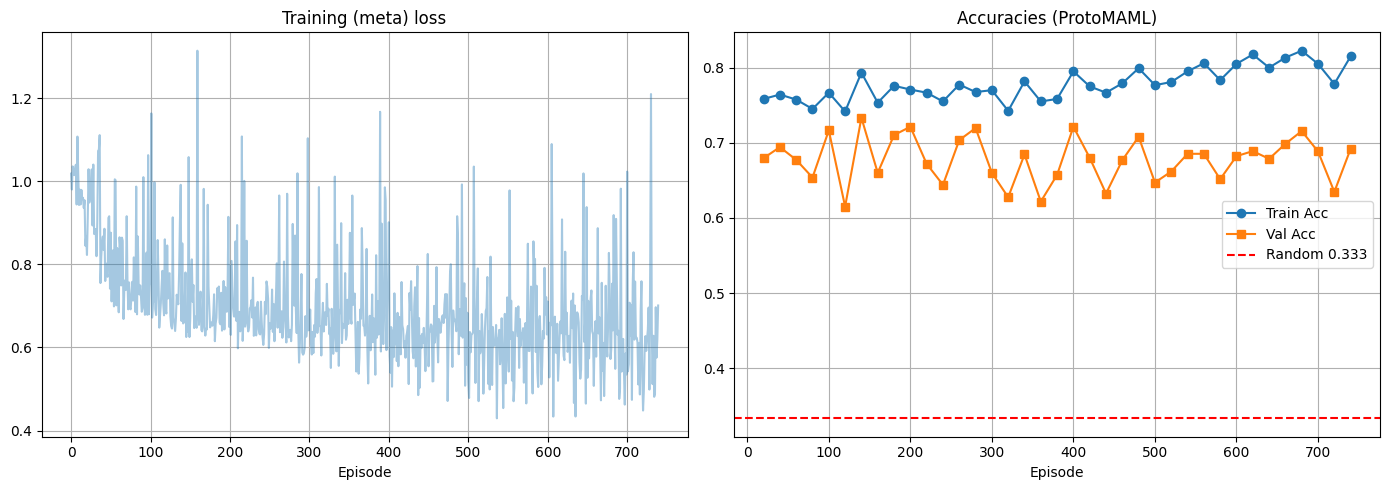

In [ ]:
# Cell 16 - training curves (requires train_losses, val_accs, train_accs from training loop)
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(train_losses, alpha=0.4)
plt.title("Training (meta) loss")
plt.xlabel("Episode")
plt.grid(True)
plt.subplot(1,2,2)
eval_steps = [i * EVAL_EVERY for i in range(1, len(val_accs) + 1)]
plt.plot(eval_steps, train_accs, marker='o', label="Train Acc")
plt.plot(eval_steps, val_accs, marker='s', label="Val Acc")
plt.axhline(1.0 / N, color='r', linestyle='--', label=f"Random {1.0/N:.3f}")
plt.title("Accuracies (ProtoMAML)")
plt.xlabel("Episode")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Preparing t-SNE subset...
t-SNE subset size: 408 from 10 groups
Embeddings shape: (408, 256)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 408 samples in 0.001s...
[t-SNE] Computed neighbors for 408 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 408 / 408
[t-SNE] Mean sigma: 0.066024


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.039478
[t-SNE] KL divergence after 1000 iterations: 0.118385
t-SNE done: (408, 2)
t-SNE metrics: sil=0.110 ARI=0.549 NMI=0.709 Inter/Intra=1.958


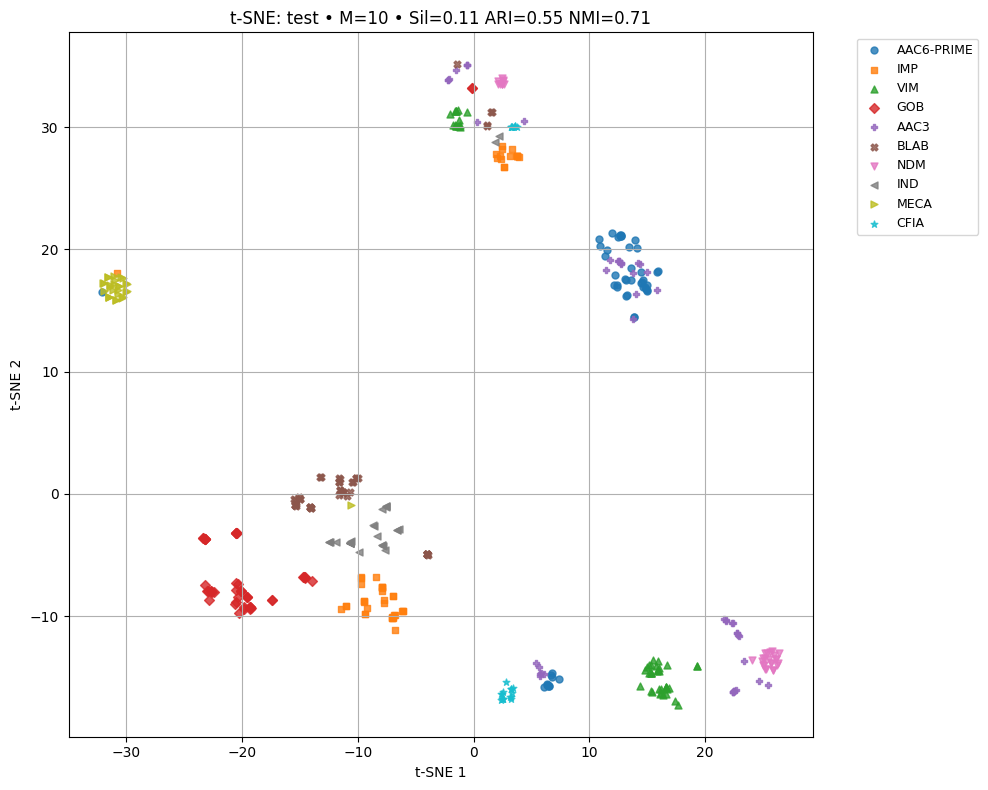

Saved t-SNE results to: tsne_results_test.csv


In [ ]:
# Cell 17 - t-SNE on subset of embeddings with diagnostics
# Choose subset source: "train", "val", or "test"
SUBSET_SOURCE = "test"
TOP_M_CLASSES = 10
N_PER_CLASS = 50
TSNE_PERPLEX = 30
RANDOM_STATE = 42

print("Preparing t-SNE subset...")
base_df = {"train": train_df, "val": val_df, "test": test_df}.get(SUBSET_SOURCE, test_df)
counts = base_df['group'].value_counts()
kept_labels = counts.head(TOP_M_CLASSES).index.tolist()

subset_list = []
for lab in kept_labels:
    sub = base_df[base_df['group'] == lab]
    if len(sub) > N_PER_CLASS:
        sub = sub.sample(N_PER_CLASS, random_state=RANDOM_STATE)
    subset_list.append(sub)
subset = pd.concat(subset_list).reset_index(drop=True)
print(f"t-SNE subset size: {len(subset)} from {len(kept_labels)} groups")

# Encode subset
ids = [encode_ids(s, KMER_K) for s in subset['sequence'].tolist()]
tok = np.full((len(ids), MAX_LEN), stoi[PAD], dtype=np.int64)
for i, seq in enumerate(ids):
    s = seq[:MAX_LEN]
    tok[i, :len(s)] = s
num = subset[['gc_content', 'seq_len']].to_numpy(np.float32)
num = (num - num_mean) / num_std
y_str = subset['group'].values

# Generate embeddings
model.eval()
with torch.no_grad():
    Xt = torch.from_numpy(tok).long().to(device)
    Xn = torch.from_numpy(num).float().to(device)
    Z = model(Xt, Xn).detach().cpu().numpy()

print("Embeddings shape:", Z.shape)
perplexity = min(TSNE_PERPLEX, max(5, len(Z) // 4 - 1))
tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', learning_rate='auto',
            n_iter=1000, random_state=RANDOM_STATE, verbose=1)
Z2 = tsne.fit_transform(Z)
print("t-SNE done:", Z2.shape)

# compute metrics
label_to_int = {lab: i for i, lab in enumerate(kept_labels)}
y_int = np.array([label_to_int.get(v, -1) for v in y_str])
sil = silhouette_score(Z2, y_int, metric='euclidean') if len(np.unique(y_int))>1 else float('nan')
kmeans = KMeans(n_clusters=len(kept_labels), n_init='auto', random_state=RANDOM_STATE)
pred = kmeans.fit_predict(Z2)
ari = adjusted_rand_score(y_int, pred)
nmi = normalized_mutual_info_score(y_int, pred)

D = np.sqrt(((Z2[:,None,:] - Z2[None,:,:])**2).sum(axis=2))
intra = np.array([D[i, y_int == y_int[i]].mean() for i in range(len(Z2))])
inter = np.array([D[i, y_int != y_int[i]].mean() for i in range(len(Z2))])
mean_intra = float(np.nanmean(intra))
mean_inter = float(np.nanmean(inter))
ratio = mean_inter / mean_intra if mean_intra>0 else float('nan')

print("t-SNE metrics: sil={:.3f} ARI={:.3f} NMI={:.3f} Inter/Intra={:.3f}".format(sil, ari, nmi, ratio))

# Plot
plt.figure(figsize=(10,8))
markers = ["o", "s", "^", "D", "P", "X", "v", "<", ">", "*"]
for i, lab in enumerate(kept_labels):
    idx = (y_str == lab)
    plt.scatter(Z2[idx, 0], Z2[idx, 1], s=25, marker=markers[i % len(markers)], alpha=0.8, label=lab[:20])
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.title(f"t-SNE: {SUBSET_SOURCE} • M={len(kept_labels)} • Sil={sil:.2f} ARI={ari:.2f} NMI={nmi:.2f}")
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=9)
plt.grid(True); plt.tight_layout()
plt.show()

# Save tsne results
tsne_results = pd.DataFrame({'tsne_1': Z2[:,0], 'tsne_2': Z2[:,1], 'label': y_str})
for i in range(min(5, Z.shape[1])):
    tsne_results[f'emb_{i}'] = Z[:, i]
tsne_results.to_csv(f'tsne_results_{SUBSET_SOURCE}.csv', index=False)
print("Saved t-SNE results to:", f"tsne_results_{SUBSET_SOURCE}.csv")


In [ ]:
# Cell 18 - save
torch.save(model.state_dict(), "final_protomaml_hier.pt")
import pickle
with open("group_mappings.pkl", "wb") as f:
    pickle.dump({
        "group2idx": group2idx,
        "idx2group": idx2group,
        "mech2idx": mech2idx,
        "idx2mech": idx2mech,
        "class2idx": class2idx,
        "idx2class": idx2class,
        "group_to_mech_idx": group_to_mech_idx,
        "group_to_class_idx": group_to_class_idx,
        "stoi": stoi,
        "itos": itos
    }, f)
print("Saved model and mappings.")


Saved model and mappings.


In [ ]:
print("Unique groups:", len(group2idx))
print("Unique mechanisms:", len(mech2idx))
print("Mapping entries:", len(group_to_mech_idx))

# Sanity check for missing mappings
missing = [g for g in group2idx if g not in group_to_mech_idx]
if missing:
    print("⚠️ Missing group→mechanism mappings:", missing)
else:
    print("✅ All groups mapped to mechanisms.")

Unique groups: 1448
Unique mechanisms: 233
Mapping entries: 1448
⚠️ Missing group→mechanism mappings: ['A16S', 'AAC2-PRIME', 'AAC3', 'AAC3-PRIME', 'AAC6-PRIME', 'AAK', 'ABAF', 'ABAQ', 'ABCA', 'ABEM', 'ABES', 'ABUO', 'ACC', 'ACI', 'ACN', 'ACR3', 'ACRA', 'ACRB', 'ACRC', 'ACRD', 'ACRE', 'ACRF', 'ACRR', 'ACRS', 'ACT', 'ACTA', 'ACTP', 'ACTP1', 'ACTPC', 'ACTR', 'ACTS', 'ADC', 'ADEA', 'ADEB', 'ADEC', 'ADED', 'ADEE', 'ADEF', 'ADEG', 'ADEH', 'ADEI', 'ADEJ', 'ADEK', 'ADEL', 'ADEN', 'ADER', 'ADES', 'ADET1', 'ADET2', 'AER', 'AFM', 'AHPC', 'AIM', 'AIOA', 'AIOB', 'AIOE', 'AIOR', 'AIOS', 'AIOX', 'ALG', 'ALI', 'ALMG', 'ALR', 'ALU1P', 'AMPC', 'AMPCR', 'AMPH', 'AMRA', 'AMRB', 'AMVA', 'ANA', 'ANT2-DPRIME', 'ANT3-DPRIME', 'ANT4-PRIME', 'ANT6', 'ANT9', 'APH2-DPRIME', 'APH3-DPRIME', 'APH3-PRIME', 'APH4', 'APH6', 'APH7-DPRIME', 'APH9', 'APMA', 'AQU', 'ARIR', 'ARL', 'ARLR', 'ARLS', 'ARMA', 'ARMR', 'ARNA', 'ARNT', 'ARR', 'ARRA', 'ARRB', 'ARSA', 'ARSB', 'ARSBM', 'ARSC', 'ARSCM', 'ARSD', 'ARSDM', 'ARSH', 'ARSHN'